## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Косарев Е.А.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

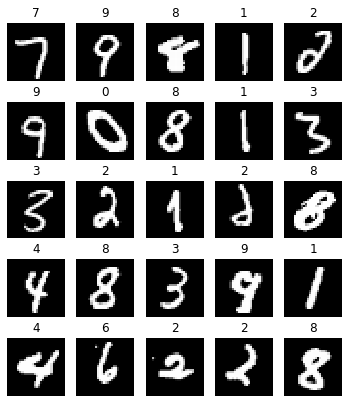

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=0.1)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
#sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

#init_func = normal
init_func = normal
#init_func = good_grad

In [8]:
def make_layers(init_layer):
    layers = []
    sizes = [28*28] + [500] * 10 + [10]

    for size_input, size_output in zip(sizes, sizes[1:]):
    
        layer = nn.Linear(size_input, size_output)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        init_layer(layer, size_input, size_output) # сюда надо подставить другие параметры

        layers.append(layer)
        layers.append(nn.Tanh())
    
    print(len(layers))
    del layers[-1]
    return layers

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [9]:


network = nn.Sequential(*make_layers(init_layer))

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

22
forward 1.0270507335662842
forward 0.8514829277992249
forward 0.7893153429031372
forward 0.7695194482803345
forward 0.7631908059120178
forward 0.7658132314682007
forward 0.7634537816047668
forward 0.7656294107437134
forward 0.766764760017395
forward 0.7645149230957031
forward 0.7642693519592285
backward 0.024037007242441177
backward 0.01445783395320177
backward 0.014064254239201546
backward 0.013373875990509987
backward 0.01360228005796671
backward 0.01434233132749796
backward 0.016087912023067474
backward 0.019060833379626274
backward 0.021978862583637238
backward 0.024977298453450203
backward 0.024003010243177414


/home/evgenij_kosarev/miniconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [10]:
def init_layer_xavier(layer, prev_s, next_s):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-np.sqrt(6 / (prev_s + next_s)), np.sqrt(6 / (prev_s + next_s)))
    
def init_layer_he(layer, prev_s, next_s):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(0, 2 / next_s)

In [11]:
network = nn.Sequential(*make_layers(init_layer_he))

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

22
forward 1.0270507335662842
forward 0.11532987654209137
forward 0.010397390462458134
forward 0.0009441087022423744
forward 8.271559636341408e-05
forward 7.4487529673206154e-06
forward 6.670769039374136e-07
forward 5.938080249734412e-08
forward 5.309090944649597e-09
forward 4.747845450125965e-10
forward 4.2372008679514295e-11
backward 0.024037007242441177
backward 0.06669554114341736
backward 0.006040665786713362
backward 0.0005407780990935862
backward 4.808963058167137e-05
backward 4.507954145083204e-06
backward 4.09027052228339e-07
backward 3.583578944699184e-08
backward 3.1644864506574777e-09
backward 2.7321137019420405e-10
backward 2.295525922124675e-11


In [12]:
network = nn.Sequential(*make_layers(init_layer_xavier))

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

22
forward 1.0270507335662842
forward 0.6573994159698486
forward 0.5019680857658386
forward 0.41571173071861267
forward 0.355618417263031
forward 0.32235029339790344
forward 0.2947220206260681
forward 0.27194270491600037
forward 0.2546132504940033
forward 0.23766961693763733
forward 0.22661331295967102
backward 0.024037007242441177
backward 0.01934729516506195
backward 0.01872195303440094
backward 0.016936281695961952
backward 0.01547984965145588
backward 0.014047504402697086
backward 0.012591942213475704
backward 0.011560805141925812
backward 0.009694505482912064
backward 0.007334018126130104
backward 0.0044914972968399525


<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [13]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [14]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [28]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size_input, size_output))
    if size_output != 10:
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.03))   
        
#del layers[-1]

In [30]:
layers

[Linear(in_features=196, out_features=128, bias=True),
 ReLU(),
 Dropout(p=0.03, inplace=False),
 Linear(in_features=128, out_features=128, bias=True),
 ReLU(),
 Dropout(p=0.03, inplace=False),
 Linear(in_features=128, out_features=10, bias=True)]

Epoch 9... (Train/Test) NLL: 0.062/0.067	Accuracy: 0.980/0.977


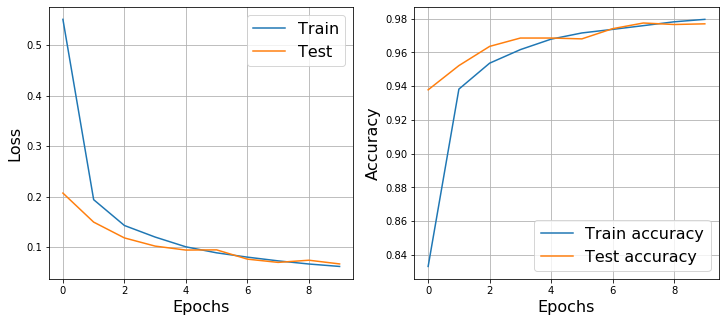

CPU times: user 18min, sys: 1min, total: 19min 1s
Wall time: 3min 11s


([0.5510937359128425,
  0.19395810361705354,
  0.14282061048408054,
  0.11990743186841132,
  0.10055101207340322,
  0.08866226486265977,
  0.08013827178968803,
  0.07274765138035771,
  0.06654328992391732,
  0.0617061042026289],
 [0.20699811453306222,
  0.14951835912239703,
  0.11821678903283953,
  0.10198347595862195,
  0.0941451522934286,
  0.09454170126273427,
  0.07617501055090865,
  0.06973792359091435,
  0.07404392973602383,
  0.06668835168680813],
 [0.83326674,
  0.9382218,
  0.9535803,
  0.9615983,
  0.9678005,
  0.9714597,
  0.9735808,
  0.97578514,
  0.9780562,
  0.9795109],
 [0.93779665,
  0.9521361,
  0.9635087,
  0.96845335,
  0.96845335,
  0.96795887,
  0.9739913,
  0.97735363,
  0.9764636,
  0.97685915])

In [29]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

In [35]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layers.append(DropConnect(size_input, size_output, 0.97)) 
    layers.append(nn.ReLU())
        

Epoch 9... (Train/Test) NLL: 0.194/0.508	Accuracy: 0.943/0.966


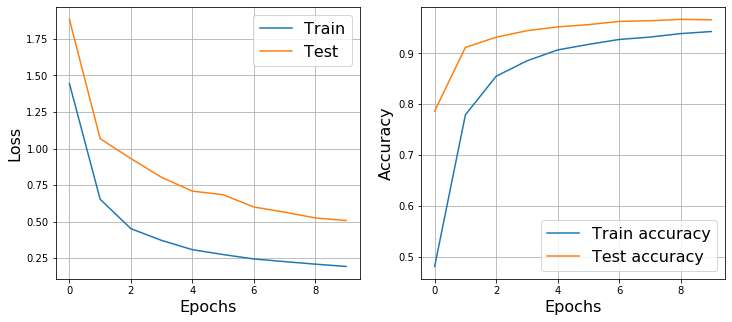

CPU times: user 18min 59s, sys: 1min 4s, total: 20min 4s
Wall time: 3min 22s


([1.444305912390955,
  0.6534456089615568,
  0.4522814482831752,
  0.37203984852157423,
  0.3088366544640649,
  0.27546783463596536,
  0.24522848376460166,
  0.2272850953534976,
  0.20982120635667081,
  0.19420673284353987],
 [1.8824816612597508,
  1.0672478905961484,
  0.9313385671216853,
  0.8026137774503683,
  0.7088466331928591,
  0.6840876011248631,
  0.6003190152305826,
  0.5651980218819425,
  0.5254709240363371,
  0.5078316614937326],
 [0.48117116,
  0.7790956,
  0.8549329,
  0.88517237,
  0.9066609,
  0.91754395,
  0.9272277,
  0.93189746,
  0.9387438,
  0.94283605],
 [0.7863924,
  0.9116891,
  0.93166536,
  0.9444225,
  0.9519383,
  0.9563885,
  0.9627176,
  0.96400315,
  0.96677214,
  0.9658821])

In [36]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [81]:
a = torch.nn.Parameter(torch.Tensor([1.0]))
a

Parameter containing:
tensor([1.], requires_grad=True)

In [82]:
b = a.repeat(3, 2)
b

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], grad_fn=<RepeatBackward>)

In [93]:
b.mean(1).repeat(b.size(1), 1)

tensor([[1., 1., 1.],
        [1., 1., 1.]], grad_fn=<RepeatBackward>)

In [207]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self):
        super(LayerNormalization, self).__init__()
        self.gamma = torch.nn.Parameter(torch.Tensor([1.0]))
        self.beta = torch.nn.Parameter(torch.Tensor([0.0]))
        
    def forward(self, x):
        batch_size,n_activations = x.size()
        #print(x.size())
        one = self.gamma.repeat(batch_size,n_activations)
        #orch.mul(one, )
        two = (x - (x.mean(1).repeat(n_activations, 1)).T) / (x.std(1).repeat(n_activations, 1) ** 0.5 + 0.0005).T
        #print('two', two.size())
        three = self.beta.repeat(batch_size,n_activations)
        #print(one.size(), two.size(), three.size(), "!")
        output = one * two + three
        
        return output

In [67]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self):
        super(LayerNormalization, self).__init__()
        self.gamma = torch.nn.Parameter(torch.Tensor([1.0]))
        self.beta = torch.nn.Parameter(torch.Tensor([0.0]))
        
    def forward(self, x):
        batch_size,n_activations = x.size()
        print(batch_size,n_activations)
        output = self.gamma.repeat(batch_size,n_activations) * \
                (x - x.mean(1).repeat(1,n_activations)) / x.std(1).repeat(1,n_activations) + \
                self.beta.repeat(batch_size,n_activations)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [51]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size_input, size_output)) 
    layers.append(nn.ReLU())
    layers.append(nn.BatchNorm1d(size_output))

In [52]:
layers

[Linear(in_features=196, out_features=128, bias=True),
 ReLU(),
 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=128, out_features=128, bias=True),
 ReLU(),
 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=128, out_features=10, bias=True),
 ReLU(),
 BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

Epoch 9... (Train/Test) NLL: 0.042/0.066	Accuracy: 0.989/0.982


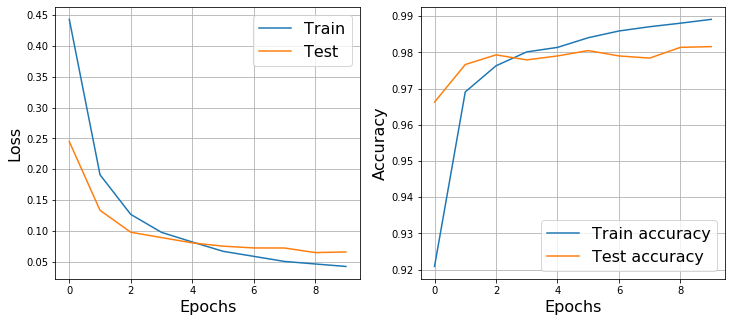

CPU times: user 22min 10s, sys: 1min 14s, total: 23min 25s
Wall time: 3min 56s


([0.44326773724322127,
  0.1910679483814026,
  0.1267593268281234,
  0.09766047954686415,
  0.08203447044197558,
  0.06696263985879132,
  0.05873945765078131,
  0.050495252636735884,
  0.0463687489176594,
  0.04235922000499994],
 [0.24505445455448538,
  0.13340583698281758,
  0.09784852180488501,
  0.08920162949192373,
  0.08061459226698815,
  0.0752731328712234,
  0.0723743392744019,
  0.07228796720457605,
  0.06485598672275679,
  0.06585544786309894],
 [0.9208977,
  0.9690943,
  0.97631264,
  0.98014945,
  0.9813933,
  0.98406404,
  0.9859297,
  0.98710686,
  0.98807853,
  0.98913914],
 [0.9662777,
  0.9766614,
  0.9793315,
  0.977947,
  0.9790348,
  0.9805182,
  0.9790348,
  0.9784415,
  0.98140824,
  0.981606])

In [53]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

In [205]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size_input, size_output)) 
    layers.append(nn.ReLU())
    layers.append(LayerNormalization())
    
layers

[Linear(in_features=196, out_features=128, bias=True),
 ReLU(),
 LayerNormalization(),
 Linear(in_features=128, out_features=128, bias=True),
 ReLU(),
 LayerNormalization(),
 Linear(in_features=128, out_features=10, bias=True),
 ReLU(),
 LayerNormalization()]

Epoch 9... (Train/Test) NLL: 0.030/0.068	Accuracy: 0.990/0.979


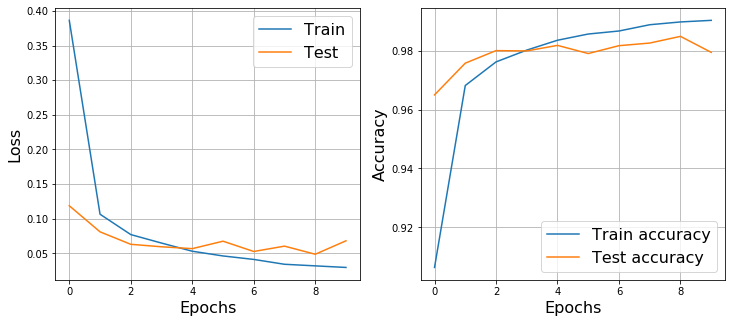

CPU times: user 19min 34s, sys: 1min, total: 20min 35s
Wall time: 3min 27s


([0.38630229908266045,
  0.10646514141403918,
  0.0770790751016677,
  0.0648211143525647,
  0.05304012677646173,
  0.046222009403166425,
  0.04121109386479089,
  0.03420871382565307,
  0.03191478007352913,
  0.02963386669329036],
 [0.11868126398023171,
  0.08104028482626699,
  0.06303008560892902,
  0.0594551578234834,
  0.056775865156816534,
  0.06752412370111369,
  0.052662704629186964,
  0.060385589723628535,
  0.04868470488522862,
  0.06808687654571442],
 [0.9063888,
  0.9681725,
  0.9761905,
  0.98019946,
  0.98355323,
  0.9856632,
  0.9866904,
  0.9888171,
  0.9897666,
  0.9903052],
 [0.9649921,
  0.97577137,
  0.98002374,
  0.97992486,
  0.9818038,
  0.9790348,
  0.9817049,
  0.9825949,
  0.9848695,
  0.9794304])

In [206]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: